## 1. Matrix Factorization

In [1]:
from scipy.optimize import minimize
import numpy as np

In [2]:
def f(UV):
    U = UV[0:3].reshape(3,1)
    V = UV[3:].reshape(1,3)
    A = np.matmul(U,V)
    sqError = ((A[0,0]-0)**2 + (A[0,1]-1)**2 + (A[1,0]-1)**2 + (A[1,2]-1)**2 + (A[2,1]-1)**2 + (A[2,2]-2)**2)
    return sqError

In [3]:
U = np.random.random([1,3])
V = np.random.random([1,3])
result = minimize(f,[U,V])

In [4]:
U_ans,V_ans = result.x[:3].reshape(3,1),result.x[3:].reshape(3,1)
A_ans = np.matmul(U_ans,np.transpose(V_ans))
print('A:\n',A_ans)
print('U:\n',U_ans)
print('V:\n',V_ans)
print('Squared Error:\n',result.fun)


A:
 [[0.48745758 0.6112881  0.9555519 ]
 [0.61128828 0.76657594 1.19829438]
 [0.955552   1.19829416 1.87314665]]
U:
 [[0.51247902]
 [0.64266601]
 [1.00460096]]
V:
 [[0.95117568]
 [1.1928061 ]
 [1.86456785]]
Squared Error:
 0.6345416392968009


## 2. Support Vector Machines

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

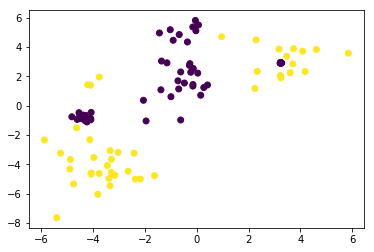

In [6]:
csv = 'kernel.csv'
data = np.genfromtxt(csv,delimiter=',')
X = data[:,1:]
Y = data[:,0]
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [7]:
from sklearn.svm import SVC
clf = SVC(gamma=0.5,kernel='rbf')
clf.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
def decision(x1,x2,clf):
    x = np.array([[x1,x2]])
    value = clf.decision_function(x)
    return value

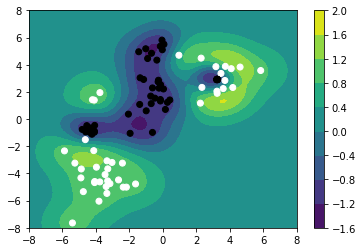

In [9]:
vdecision = np.vectorize(decision,excluded=[2])
x1list = np.linspace(-8.0,8.0,100)
x2list = np.linspace(-8.0,8.0,100)
X1, X2 = np.meshgrid(x1list,x2list)
Z = vdecision(X1,X2,clf)
cp = plt.contourf(X1,X2,Z)
plt.colorbar(cp)
plt.scatter(X[:,0],X[:,1],c=Y,cmap='gray')
plt.show()

## 3. Deep Learning

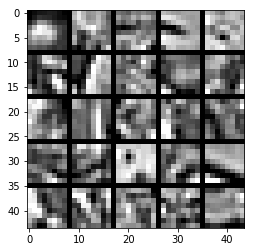

In [10]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b as minimize
from utils import normalize, tile_raster_images, sigmoid
from utils import ravelParameters, unravelParameters
from utils import initializeParameters
from utils import computeNumericalGradient
nV = 8*8 # number of visible units
nH = 25 # number of hidden units
dW = 0.0001 # weight decay term
sW = 3 # sparsity penalty term
npy = 'images.npy'
X = normalize(np.load(npy))
plt.imshow(tile_raster_images(X=X,
img_shape=(8,8),tile_shape=(5,5),
tile_spacing=(1,1)),cmap='gray')
plt.show()

In [11]:
def sparseAutoencoderCost(theta,nV,nH,dW,sW,X):
    W1,W2,b1,b2 = unravelParameters(theta,nH,nV)
    n = X.shape[0]
    z2 = np.matmul(X,W1)+ np.matmul(np.ones((n,1)),np.transpose(b1))
    a2 = sigmoid(z2)
    z3 = np.matmul(a2,W2) + np.matmul(np.ones((n,1)),np.transpose(b2))
    a3 = sigmoid(z3)
    eps = a3 - X
    loss = (norm(eps)**2)/(2*n)
    decay = (norm(W1)**2 + norm(W2)**2)/2
    # Compute sparsity terms and total cost
    rho = 0.01
    a2mean = np.mean(a2,axis=0).reshape(nH,1)
    kl = np.sum(rho*np.log(rho/a2mean)+\
    (1-rho)*np.log((1-rho)/(1-a2mean)))
    dkl = -rho/a2mean+(1-rho)/(1-a2mean)
    cost = loss+dW*decay+sW*kl
    d3 = eps*a3*(1-a3)
    d2 = (sW*dkl.T+np.dot(d3,W2.T))*a2*(1-a2)
    W1grad = np.matmul(np.transpose(X),d2)/n + dW*W1
    W2grad = np.matmul(np.transpose(a2),d3)/n + dW*W2
    b1grad = np.matmul(np.transpose(d2),np.ones((n,1)))/n
    b2grad = np.matmul(np.transpose(d3),np.ones((n,1)))/n
    grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
    print('.',end="")
    return cost,grad

In [12]:
theta = initializeParameters(nH,nV)
cost,grad = sparseAutoencoderCost(theta,nV,nH,dW,sW,X)

.

In [13]:
print('\nComparing numerical gradient with backprop gradient')
num_coords = 5
indices = np.random.choice(theta.size,num_coords,replace=False)
numgrad = computeNumericalGradient(lambda t:
sparseAutoencoderCost(t,nV,nH,dW,sW,X)[0],theta,indices)
subnumgrad = numgrad[indices]
subgrad = grad[indices]
diff = norm(subnumgrad-subgrad)/norm(subnumgrad+subgrad)
print('\n',np.array([subnumgrad,subgrad]).T)
print('The relative difference is',diff)


Comparing numerical gradient with backprop gradient
..........
 [[0.64742942 0.64742942]
 [0.01875619 0.01875619]
 [0.01232189 0.01232189]
 [0.0120385  0.0120385 ]
 [0.00366384 0.00366384]]
The relative difference is 1.5793942480482588e-10



Training neural network
...................................................................................................................................................................................................................................................................................................................................................................................................................................

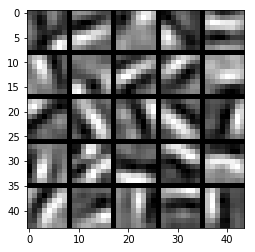

In [14]:
print('\nTraining neural network')
theta = initializeParameters(nH,nV)
opttheta,cost,messages = minimize(sparseAutoencoderCost,
theta,fprime=None,maxiter=400,args=(nV,nH,dW,sW,X))
W1,W2,b1,b2 = unravelParameters(opttheta,nH,nV)
plt.imshow(tile_raster_images(X=W1.T,
img_shape=(8,8),tile_shape=(5,5),
tile_spacing=(1,1)),cmap='gray')
plt.show()

In [16]:
# X.shape = (n, nV) # (10000,64)
# W1.shape = W1grad.shape = (nV, nH) # (64,25)
# W2.shape = W2grad.shape = (nH, nV) # (25,64)
# b1.shape = b1grad.shape = (nH,) # (25)
# b2.shape = b2grad.shape = (nV,) # (64`)


## 4. Proof of Two Equations
![title](q4Ans.jpg)